### Main Project 1 script

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import fetch_20newsgroups

np.random.seed(42)
random.seed(42)

In [2]:
# categories = ['comp.graphics', 'comp.os.ms-windows.misc',
#               'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
#               'rec.autos', 'rec.motorcycles',
#               'rec.sport.baseball', 'rec.sport.hockey']
# train_dataset = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)
# test_dataset = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42)

#### Question 1

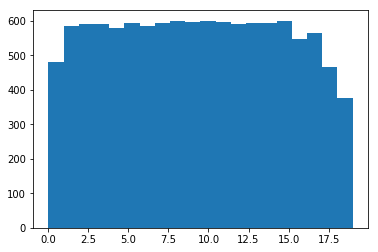

In [3]:
# Fetch all 20 news groups categories and plot a histogram of the training documents.

newsgroups_train = fetch_20newsgroups(subset='train', shuffle=True, random_state=42)
plt.hist(newsgroups_train.target, 20)
plt.show()

#### Question 2

In [4]:
########################################################################################################################
# Fetching 20NewsGroups dataset

categories = ['comp.graphics', 'comp.os.ms-windows.misc',
              'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
              'rec.autos', 'rec.motorcycles',
              'rec.sport.baseball', 'rec.sport.hockey']

twenty_train = fetch_20newsgroups(subset='train', # choose which subset of the dataset to use; can be 'train', 'test', 'all'
                                  categories=categories, # choose the categories to load; if is `None`, load all categories
                                  shuffle=True,
                                  random_state=42, # set the seed of random number generator when shuffling to make the outcome repeatable across different runs
                                  # remove=['headers'],
                                  )
twenty_test = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42)

# Change labels into binary based on two well separated classes: Computer (labels 0-3) and Recreational (labels 4-7).
twenty_train_binary_labels = np.zeros(len(twenty_train.target))
for k in range(len(twenty_train.target)):
    if twenty_train.target[k] >= 4:
        twenty_train_binary_labels[k] = 1
twenty_test_binary_labels = np.zeros(len(twenty_test.target))
for k in range(len(twenty_test.target)):
    if twenty_test.target[k] >= 4:
        twenty_test_binary_labels[k] = 1
        
i = 51
print(twenty_train.filenames[i])
print(twenty_train.target[i])
print(twenty_train.target_names)

C:\Users\zharr\scikit_learn_data\20news_home\20news-bydate-train\comp.sys.mac.hardware\51613
3
['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']


In [5]:
########################################################################################################################
# Perform lemmatization on dataset

# The lemmatizer is actually pretty complicated, it needs Parts of Speech (POS) tags
import nltk
from nltk import pos_tag
# nltk.download('punkt')#, if you need "tokenizers/punkt/english.pickle", choose it
# nltk.download('averaged_perceptron_tagger')

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN': 'n', 'JJ': 'a',
                  'VB': 'v', 'RB': 'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'


# def lemmatize_sent(list_word, wnl):
#     # Text input is string, returns array of lowercased strings(words).
#     return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag))
#             for word, tag in pos_tag(list_word)]


wnl = nltk.wordnet.WordNetLemmatizer()
def lemmatize_training(text):
    # Text input is string, returns array of lowercased strings(words).
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag))
            for word, tag in pos_tag(nltk.word_tokenize(text))]


# TODO: should this filter out the following numbers too? "4-5" "c650"
def filter_numbers(text_array):
    # Filter out any numbers found in the array of strings
    output = []
    for s in text_array:
        if not s.isdigit():
            # if not a digit...
            try:
                # if a float, filter out
                float(s)
            except ValueError:
                # if not a float, add to output
                output.append(s)
        else:
            # if a digit, filter out
            pass
    return output


def array_to_string(text_array, delimeter=""):
    # Converts an array back into a string of words using the provided delimeter to add between each word
    output = ""
    for s in text_array:
        output = output + delimeter + s
    return output


def lemmatize_and_filter(documents):
    # Performs lemmatization, and number filtering on the given documents
    lemmatized_data = []
    for i in documents:
        # lemmatize the document:
        training_tagged = pos_tag(nltk.word_tokenize(i))
        lemmatized_array = lemmatize_training(i)

        # remove numbers from document:
        filtered_array = filter_numbers(lemmatized_array)

        # reassemble back to string:
        lemmatized_string = array_to_string(filtered_array, ' ')

        # add to final data list
        # print(lemmatized_string)
        lemmatized_data.append(lemmatized_string)

    return lemmatized_data


# print(lemmatized_data[0])
lemmatized_training = lemmatize_and_filter(twenty_train.data)
lemmatized_testing = lemmatize_and_filter(twenty_test.data)

In [6]:
########################################################################################################################
# Push lemmatized documents through CountVectorizer

# count_vect = CountVectorizer(min_df=3)
from sklearn.feature_extraction.text import CountVectorizer

# do for training
count_vect = CountVectorizer(min_df=3, stop_words='english')
X_lemmatized_train_counts = count_vect.fit_transform(lemmatized_training)

# do for testing
X_lemmatized_test_counts = count_vect.transform(lemmatized_testing)

In [7]:
########################################################################################################################
# Report shapes of TF-IDF matrices

from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()

# do for training
X_lemmatized_train_tfidf = tfidf_transformer.fit_transform(X_lemmatized_train_counts)

print(X_lemmatized_train_tfidf.shape)
print('-' * 20)
print(X_lemmatized_train_counts.toarray()[:30, :5])
print('-' * 20)
print(X_lemmatized_train_tfidf.toarray()[:30, :5])

# do for testing
X_lemmatized_test_tfidf = tfidf_transformer.transform(X_lemmatized_test_counts)

print(X_lemmatized_test_tfidf.shape)
print('-' * 20)
print(X_lemmatized_test_counts.toarray()[:30, :5])
print('-' * 20)
print(X_lemmatized_test_tfidf.toarray()[:30, :5])

(4732, 17426)
--------------------
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
--------------------
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
(3150, 17426

#### Question 3

In [8]:
# Perform LSI using the truncated SVD

from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=50, random_state=42)
X_lsi_train_reduced = svd.fit_transform(X_lemmatized_train_tfidf)
Y_lsi_train_reduced = svd.components_
print(X_lsi_train_reduced.shape)
print(svd.components_.shape)

X_lsi_test_reduced = svd.transform(X_lemmatized_test_tfidf)
Y_lsi_test_reduced = svd.components_
print(X_lsi_train_reduced.shape)
print(svd.components_.shape)

(4732, 50)
(50, 17426)
(4732, 50)
(50, 17426)


In [9]:
# Perform NMF

from sklearn.decomposition import NMF

model = NMF(n_components=50, init='random', random_state=42)
W_nmf_train_reduced = model.fit_transform(X_lemmatized_train_tfidf)
H_nmf_train_reduced = model.components_

print(W_nmf_train_reduced.shape)
print(H_nmf_train_reduced.shape)

W_nmf_test_reduced = model.transform(X_lemmatized_test_tfidf)
H_nmf_test_reduced = model.components_

(4732, 50)
(50, 17426)


In [10]:
# Compare LSI and NMF

nmf_val = np.linalg.norm(X_lemmatized_train_tfidf - np.matmul(W_nmf_train_reduced, H_nmf_train_reduced), 'fro')**2
lsi_val = np.linalg.norm(X_lemmatized_train_tfidf - np.matmul(X_lsi_train_reduced, Y_lsi_train_reduced), 'fro')**2

print('NMF: ', nmf_val)
print('LSI: ', lsi_val)

NMF:  4156.10431111368
LSI:  4119.969936285531


#### Question 5

In [11]:
# Train an unregularized logistic regression classifier.

from sklearn.linear_model import LogisticRegression

# To be unregularized, we make the inverse of the regularization strength C 
# to be large to approximate an unregularized classifier.
clf = LogisticRegression(random_state=42, C=500, max_iter=100, solver='lbfgs').fit(X_lsi_train_reduced, twenty_train_binary_labels)

# score = clf.decision_function(X_lsi_test_reduced)
predicted = clf.predict(X_lsi_test_reduced)

In [12]:
# Find confusion matrix, accuracy, precision-recall, and F-1 scores

# Confusion matrix
from sklearn.metrics import confusion_matrix

print('Confusion matrix: \n', confusion_matrix(twenty_test_binary_labels, predicted))

# Accuracy
from sklearn.metrics import accuracy_score

print('Accuracy: ', accuracy_score(twenty_test_binary_labels, predicted))

# Average precision-recall score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# print('Average precision-recall score:', average_precision_score(twenty_test.target, predicted))
print('Precision score: ', precision_score(twenty_test_binary_labels, predicted))
print('Recall score: ', recall_score(twenty_test_binary_labels, predicted))

# F-1 score
from sklearn.metrics import f1_score

print('F-1 score:', f1_score(twenty_test_binary_labels, predicted))

Confusion matrix: 
 [[1508   52]
 [  35 1555]]
Accuracy:  0.9723809523809523
Precision score:  0.9676415681393902
Recall score:  0.9779874213836478
F-1 score: 0.9727869878010635


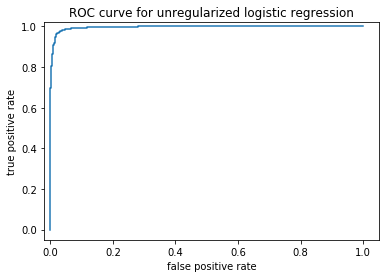

In [13]:
# ROC curve

from sklearn.metrics import roc_curve

score = clf.decision_function(X_lsi_test_reduced)
fpr, tpr, thresholds = roc_curve(twenty_test_binary_labels, score)

plt.figure()
plt.plot(fpr, tpr)
plt.title('ROC curve for unregularized logistic regression')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(left=-0.02)
plt.ylim(top=1.02)
plt.show()

Optimal regularization strength for L1 Regulation:  [0.1]
Accuracy with L1 Regulation for L1 Regulation:  0.973015873015873
Average precision-recall score for L1 Regulation: 0.957519138728885
Precision score for L1 Regulation:  0.9665220086794792
Recall score for L1 Regulation:  0.980503144654088
F-1 score for L1 Regulation: 0.9734623790196691


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1917: ChangedBehaviorWarning: The long-standing behavior to use the accuracy score has changed. The scoring parameter is now used. This warning will disappear in version 0.22.
  ChangedBehaviorWarning)


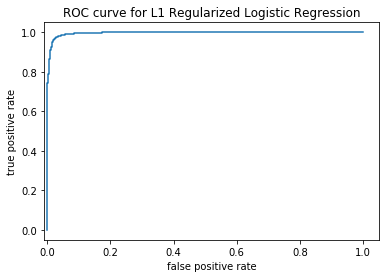


Optimal regularization strength for L2 regulation:  [0.01]
Accuracy with L2 Regulation:  0.9733333333333334
Average precision-recall score for L2 Regulation: 0.9581070282257136
Precision score for L2 Regulation:  0.96712158808933
Recall score for L2 Regulation:  0.980503144654088
F-1 score for L2 Regulation: 0.9737663960024984


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1917: ChangedBehaviorWarning: The long-standing behavior to use the accuracy score has changed. The scoring parameter is now used. This warning will disappear in version 0.22.
  ChangedBehaviorWarning)


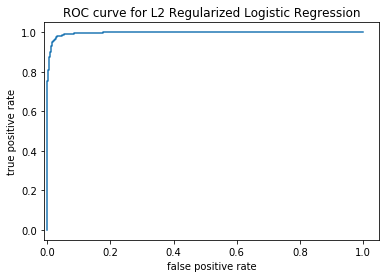

In [14]:
from sklearn.linear_model import LogisticRegressionCV

# Define training and testing data sets
X_train = X_lsi_train_reduced
y_train = twenty_train_binary_labels

X_test = X_lsi_test_reduced
y_test = twenty_test_binary_labels

# Define regularization strength values here
REG_STRENGTH_OPTIONS = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

# Determine regulation strength for L1 regulation
clf_L1 = LogisticRegressionCV(random_state=42, Cs=REG_STRENGTH_OPTIONS, cv=5, penalty='l1', scoring='accuracy', solver = 'liblinear').fit(X_train, y_train)
l1_reg_strength = 1/clf_L1.C_ # Regulization strength is inverse of optimal Cs
predicted_L1 = clf_L1.predict(X_test)

# Display L1 Stats
print('Optimal regularization strength for L1 Regulation: ', l1_reg_strength)
print('Accuracy with L1 Regulation for L1 Regulation: ', clf_L1.score(X_test, y_test))
print('Average precision-recall score for L1 Regulation:', average_precision_score(y_test, predicted_L1))
print('Precision score for L1 Regulation: ', precision_score(y_test, predicted_L1))
print('Recall score for L1 Regulation: ', recall_score(y_test, predicted_L1))
print('F-1 score for L1 Regulation:', f1_score(y_test, predicted_L1))

# L1 ROC Curve
score_L1 = clf_L1.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, score_L1)

plt.figure()
plt.plot(fpr, tpr)
plt.title('ROC curve for L1 Regularized Logistic Regression')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(left=-0.01)
plt.show()

# Determine regulation strength for L2 regulation
clf_L2 = LogisticRegressionCV(random_state=42, Cs=REG_STRENGTH_OPTIONS, cv=5, penalty='l2', scoring='accuracy', solver = 'liblinear').fit(X_train, y_train)
L2_reg_strength = 1/clf_L2.C_ # Regulization strength is inverse of optimal Cs
predicted_L2 = clf_L2.predict(X_test)

# Display L2 Stats
print('\nOptimal regularization strength for L2 regulation: ', L2_reg_strength)
print('Accuracy with L2 Regulation: ', clf_L2.score(X_test, y_test))
print('Average precision-recall score for L2 Regulation:', average_precision_score(y_test, predicted_L2))
print('Precision score for L2 Regulation: ', precision_score(y_test, predicted_L2))
print('Recall score for L2 Regulation: ', recall_score(y_test, predicted_L2))
print('F-1 score for L2 Regulation:', f1_score(y_test, predicted_L2))

# L2 ROC Curve
score_L2 = clf_L2.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, score_L2)

plt.figure()
plt.plot(fpr, tpr)
plt.title('ROC curve for L2 Regularized Logistic Regression')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(left=-0.01)
plt.show()

#### Question 6

In [15]:
########################################################################################################################
# Train a Naive Bayes Gaussian classifier on the reduced TFIDF training set from problem 3

from sklearn.naive_bayes import GaussianNB

Accuracy for Gaussian NB from LSI:  0.8974603174603175
Average precision-recall score for Gaussian NB from LSI: 0.8368804639741867
Precision score for Gaussian NB from LSI:  0.8452316076294278
Recall score for Gaussian NB from LSI:  0.9754716981132076
F-1 score for Gaussian NB from LSI: 0.9056934306569343


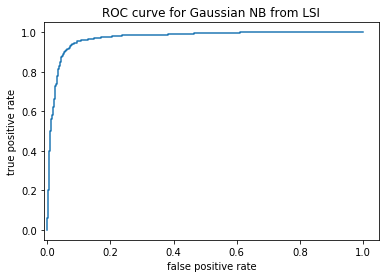

In [16]:
########################################################################################################################
# Generate stats for GaussianNB using LSI for reduction

# Define training and testing data sets
X_train = X_lsi_train_reduced
y_train = twenty_train_binary_labels

X_test = X_lsi_test_reduced
y_test = twenty_test_binary_labels

clf = GaussianNB().fit(X_train, twenty_train_binary_labels)

predicted = clf.predict(X_test)

# Display GNB Stats
print('Accuracy for Gaussian NB from LSI: ', clf.score(X_test, y_test))
print('Average precision-recall score for Gaussian NB from LSI:', average_precision_score(y_test, predicted))
print('Precision score for Gaussian NB from LSI: ', precision_score(y_test, predicted))
print('Recall score for Gaussian NB from LSI: ', recall_score(y_test, predicted))
print('F-1 score for Gaussian NB from LSI:', f1_score(y_test, predicted))

# GNB ROC Curve
prob_score = clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, prob_score[:, 1])

plt.figure()
plt.plot(fpr, tpr)
plt.title('ROC curve for Gaussian NB from LSI')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(left=-0.01)
plt.show()

Accuracy for Gaussian NB for NMF:  0.9374603174603174
Average precision-recall score for Gaussian NB for NMF: 0.905859525045954
Precision score for Gaussian NB for NMF:  0.9259938837920489
Recall score for Gaussian NB for NMF:  0.9522012578616352
F-1 score for Gaussian NB for NMF: 0.9389147286821706


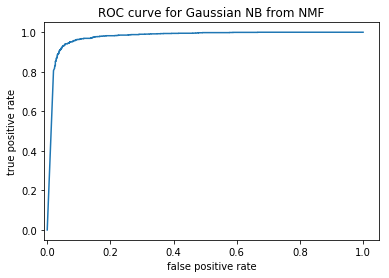

In [17]:
########################################################################################################################
# Generate stats for GaussianNB using NMF for reduction

# Define training and testing data sets
X_train = W_nmf_train_reduced
y_train = twenty_train_binary_labels

X_test = W_nmf_test_reduced
y_test = twenty_test_binary_labels

clf = GaussianNB().fit(X_train, twenty_train_binary_labels)

predicted = clf.predict(X_test)

# Display GNB Stats
print('Accuracy for Gaussian NB for NMF: ', clf.score(X_test, y_test))
print('Average precision-recall score for Gaussian NB for NMF:', average_precision_score(y_test, predicted))
print('Precision score for Gaussian NB for NMF: ', precision_score(y_test, predicted))
print('Recall score for Gaussian NB for NMF: ', recall_score(y_test, predicted))
print('F-1 score for Gaussian NB for NMF:', f1_score(y_test, predicted))

# GNB ROC Curve
prob_score = clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, prob_score[:, 1])

plt.figure()
plt.plot(fpr, tpr)
plt.title('ROC curve for Gaussian NB from NMF')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(left=-0.01)
plt.show()